# Approach 2

Getting back into it after some time with a new approach for finding patterns. Initial exploration and analysis.

### Init

In [615]:
import polars as pl
from polars import selectors as cs
from matplotlib import pyplot as plt
import os
import statsmodels.api as sm
import numpy as np
import scipy as sp
import seaborn as sns
from datetime import datetime


In [616]:
DEBUG = False
WINDOW_SIZE = 10

np.seterr(divide='ignore', invalid='ignore')


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

### Load and add dummy tickers

In [617]:
path = os.path.join('data', 'silver', 'prices_with_nrdy')

df = pl.read_parquet(path)

# dummy 1
dummy_dfs = []
k = np.log(1.1) / 260
dummy_1_f = lambda x: (100 * np.e ** (k * x) - 10 * (x // 50) + 10 / 50 * x)

dummy_dfs.append(df
    .filter(pl.col('ticker') == pl.lit('NRDY'))
    .with_columns(
        pl.lit('DUMMY1').alias('ticker'),
        dummy_1_f(pl.col('date').rank() - 1).alias('price')
    )
)

# dummy 2
size = dummy_dfs[0].shape[0]

np.random.seed(int(datetime.now().timestamp()))
noise = (np.random.random(size) -.5) * 20

dummy_dfs.append(dummy_dfs[0]
    .with_columns(
        pl.lit('DUMMY2').alias('ticker'),
       (pl.col('price') - pl.lit(noise)).alias('price') 
    )
)

# dummy 3 (more variance)
noise_2 = (np.random.random(size) -.5) * 100

dummy_dfs.append(dummy_dfs[0]
    .with_columns(
        pl.lit('DUMMY3').alias('ticker'),
       (pl.col('price') - pl.lit(noise_2)).alias('price') 
    )
)

# dummy 4 (spikes are uneven)
dummy_4_f = lambda x: 100 * np.e ** (k * x)
dummy_4_prices = [dummy_4_f(x) for x in range(size)]
i = 10
while i < size:
    i += 50 + np.random.randint(-10, 10)
    if i < size:
        dummy_4_prices[i] -= 10

dummy_dfs.append(
    dummy_dfs[0]
    .with_columns(
        pl.lit('DUMMY4').alias('ticker'),
        pl.Series(dummy_4_prices).alias('price')
    )
)

# dummy 5 (some spikes are missing)
dummy_5_f = lambda x: 100 * np.e ** (k * x)
dummy_5_prices = [dummy_5_f(x) for x in range(size)]
i = 10
while i < size:
    i += 50 + np.random.randint(-10, 10)
    if i < size:
        if np.random.random(1) > .2:
            dummy_5_prices[i] -= 10

dummy_dfs.append(
    dummy_dfs[0]
    .with_columns(
        pl.lit('DUMMY5').alias('ticker'),
        pl.Series(dummy_5_prices).alias('price')
    )
)


df = pl.concat([df, *dummy_dfs])

display(df)

date,ticker,price
date,str,f64
1994-03-18,"""SCSC""",1.71875
1994-03-21,"""SCSC""",1.90625
1994-03-22,"""SCSC""",1.9375
1994-03-23,"""SCSC""",2.09375
1994-03-24,"""SCSC""",2.09375
…,…,…
2024-04-26,"""DUMMY5""",136.910469
2024-04-29,"""DUMMY5""",136.960667
2024-04-30,"""DUMMY5""",137.010882


### Plot price over time

In [618]:
def plot_price(df, ticker=None, x='date', y='price'):
    if not ticker:
        ticker = ''

    dates = df[x]
    prices = df[y]

    fig, ax = plt.subplots()
    ax.plot(dates, prices)
    # ax.scatter(dates, prices, s=5)
    plt.title(ticker)
    plt.show()
    

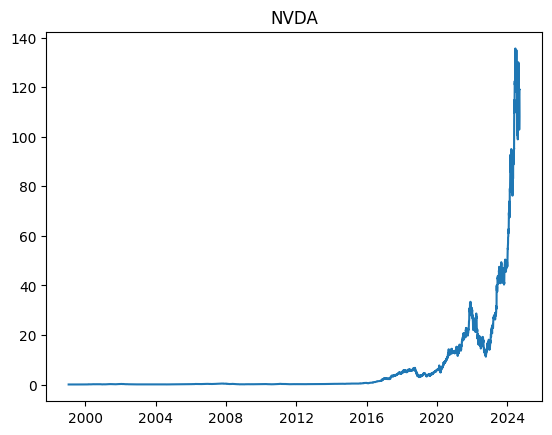

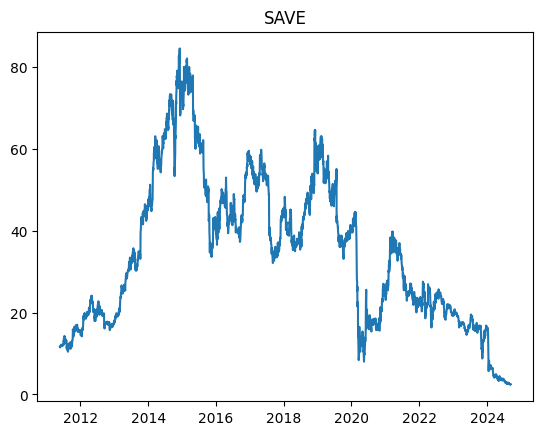

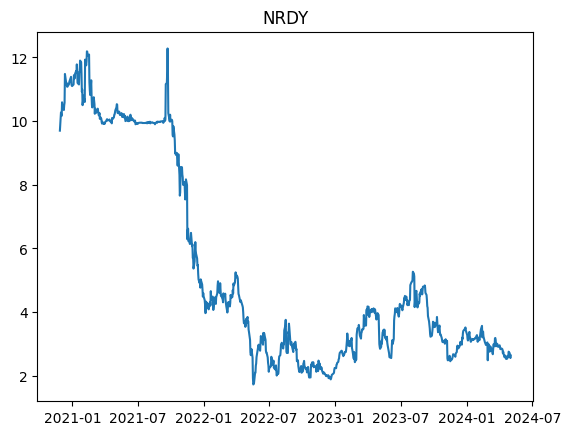

In [619]:
test_tickers = ['NRDY', 'NVDA', 'SAVE']

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

for ticker, group_df in filtered_df.group_by('ticker'):
    plot_price(group_df, ticker[0])



### Detrending

In [620]:
def plot_detrended(ticker, actuals, predictions, adjusted):
    x = list(range(0, len(actuals)))

    fig, ax = plt.subplots()
    ax.scatter(x, actuals, s=5)
    ax.plot(x, predictions)
    ax.plot(x, adjusted)
    ax.set_title(ticker)
    plt.xticks(rotation=45)
    plt.show()

In [621]:
def detrend_lin_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    ticker = df['ticker'][0]

    df = df.sort(pl.col('date'))

    rows, cols = df.shape

    # create X and y
    X = list(range(0, rows))
    X = sm.add_constant(X)
    y = df['price'].to_numpy()

    # fit model
    model = sm.OLS(y, X)
    results = model.fit()

    # make predictions
    predictions = results.predict()

    # detrend using model predictions
    df = df.with_columns(pl.col('price') - predictions)

    if DEBUG:
        print(results.summary())

        plot_detrended(ticker, y, predictions, df['price'])
    
    return df



In [622]:
def detrend_exp_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns

    df = df.with_columns(pl.col('price').log1p())

    df = detrend_lin_reg(df)

    return df



In [623]:
# DEBUG = True
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_lin_reg)

In [624]:
DEBUG = False
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_exp_reg)

Regression detrending isn't working well on tickers that have two distinct trends. 

In [625]:
def detrend_moving_avg(df):
    # checks
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    # get ticker
    ticker = df['ticker'][0]

    # calculate rolling average
    df = df.sort(pl.col('date')) \
    .with_columns(pl.col('price').rolling_mean(WINDOW_SIZE).alias('rolling_avg')) \
    .with_columns(((pl.col('price') - pl.col('rolling_avg')) / pl.col('rolling_avg')).alias('adjusted'))

    if DEBUG:
        with pl.Config(tbl_rows=218):
            display(df)
            
        plot_detrended(ticker, df['price'], df['rolling_avg'], df['adjusted'])

    # remove and rename unneeded columns
    df = df.select(pl.col('date'), pl.col('ticker'), pl.col('adjusted').alias('price'))

    
    return df



##### Testing detrending

In [626]:
DEBUG = False
test_tickers = ['NRDY', 'NVDA', 'DUMMY1'] + df['ticker'].unique().to_list()[:5]
test_tickers = ['DUMMY1']

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_moving_avg)

Rolling average seems to be the best option.

In [627]:
def fft(df):
    y = df['price'].to_numpy()

    N = y.shape[-1]


    # a = sp.sin(list(range(0, a.shape[-1])))

    yf = sp.fft.fft(y)

    if DEBUG:
        xf = sp.fft.fftfreq(N)[:N//2]

        fig, ax = plt.subplots()
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

        plt.show()
        # display(xf)


    return df

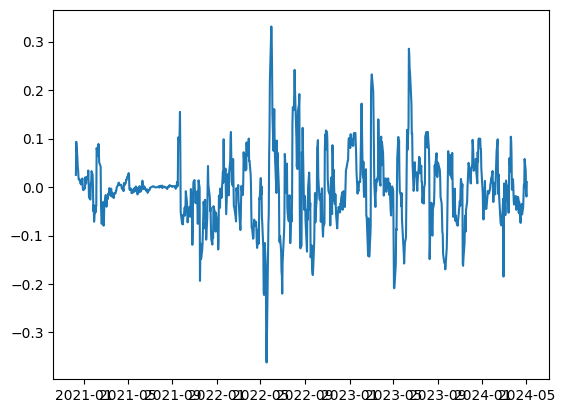

In [628]:
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:1]
test_tickers = test_tickers[:1]

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

DEBUG = False
detrended_df = (
    filtered_df.group_by('ticker').map_groups(detrend_moving_avg).drop_nulls()
    # .with_columns(pl.when(abs(pl.col('price')) > 1.1).then(pl.col('price')).otherwise(0).alias('price'))
)

plot_price(detrended_df)
DEBUG = False
fft_df = detrended_df.group_by('ticker').map_groups(fft)
# display(fft_df)

### Smoothing function

In [629]:
smoothing_distance = 10
sx_int = lambda x: -1 / 3 * x ** 3 + smoothing_distance ** 2 * x
A = sx_int(smoothing_distance) - sx_int(-smoothing_distance)

smoothing_function = lambda x: -1 / A * (x - smoothing_distance) * (x + smoothing_distance)

print(A)

1333.3333333333335


In [630]:
def plot_psd(xf, psd, min_wavelength=None, max_wavelength=None):
    if min_wavelength:
        xf, psd = list(zip(*filter(lambda x: 1/x[0] > min_wavelength, zip(xf, psd))))
        xf = np.array(xf)
        psd = np.array(psd)

    if max_wavelength:
        xf, psd = list(zip(*filter(lambda x: 1/x[0] < max_wavelength, zip(xf, psd))))
        xf = np.array(xf)
        psd = np.array(psd)
        
    fig, ax = plt.subplots()
    sns.lineplot(x=xf, y=psd, errorbar=None)

    xtick_indices = [int(x) for x in np.linspace(1, len(xf)-1, 10)]
    xticks = xf[xtick_indices]
    xtick_labels = np.round(([*1/xf[xtick_indices]]), 1)
    plt.xticks(xticks, xtick_labels)

    max_points = sorted(zip(xf, psd), key=lambda x: x[1], reverse=True)
    for max_point in max_points[:3]:
        plt.text(max_point[0], max_point[1], np.round(1/max_point[0], 1))
    
    plt.title(ticker)
    plt.show()



### Testing FFT

['NRDY', 'DUMMY2', 'DUMMY5', 'DUMMY3', 'DUMMY4', 'DUMMY1']


x_right,x,y
f64,f64,f64
469.550469,498.584507,-0.00215
678.795775,696.816901,-0.004852
622.730047,673.789906,-0.001542
706.828638,733.860329,-0.003165
147.172535,168.197183,-0.000009
…,…,…
79.092723,109.127934,-0.000336
850.997653,850.997653,-0.00005
508.596244,549.644366,-0.001322


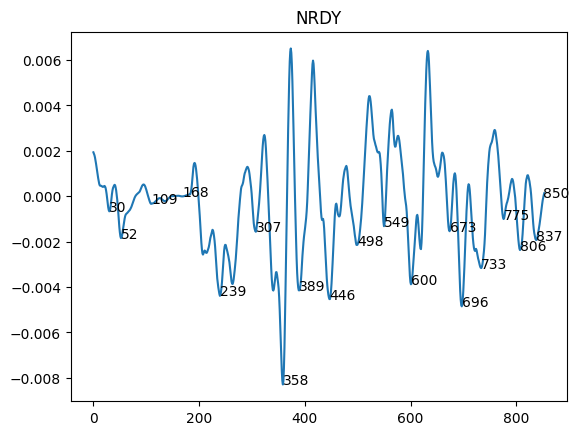

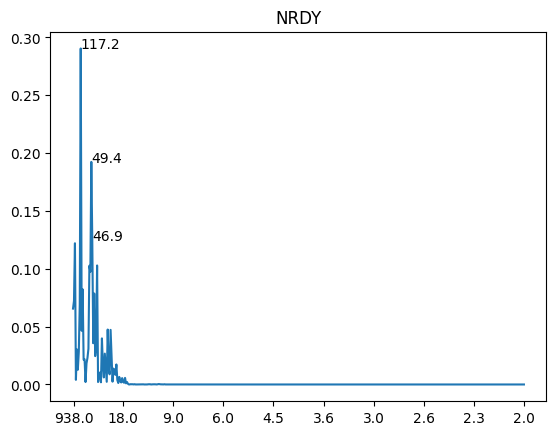

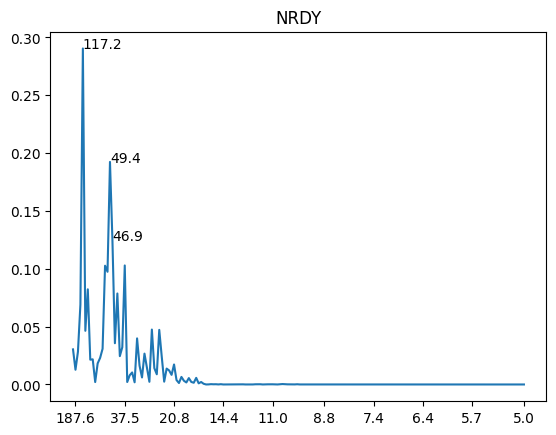

x_right,x,y
f64,f64,f64
99.116197,99.116197,-0.000259
202.237089,245.287559,-0.000806
298.349765,298.349765,-0.000152
600.704225,643.754695,-0.001065
51.059859,90.105634,-0.001081
…,…,…
154.180751,195.228873,-0.000577
653.766432,689.808685,-0.001007
580.680751,591.693662,-0.000903


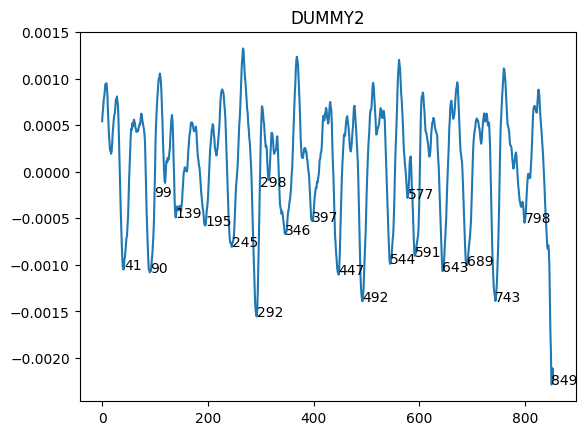

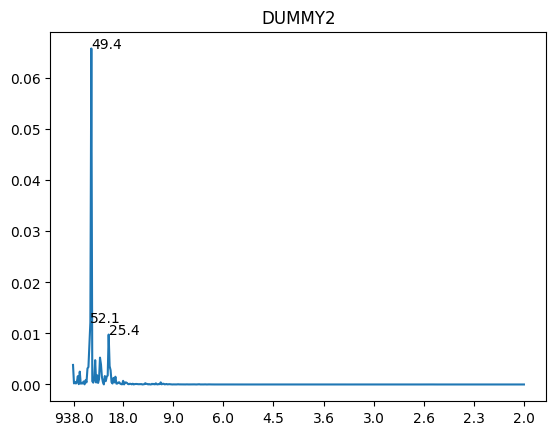

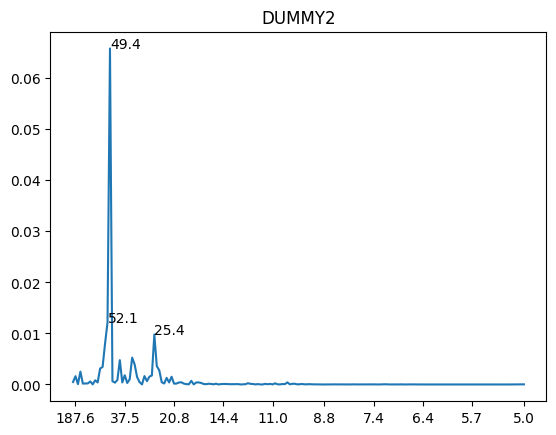

x_right,x,y
f64,f64,f64
null,40.046948,-0.000108
301.353286,452.530516,-0.000081
546.640845,677.794601,-0.000068
246.288732,297.348592,-0.00009
726.852113,812.953052,-0.000061
…,…,…
138.161972,186.21831,-0.000098
44.051643,83.097418,-0.000105
456.535211,542.63615,-0.000075


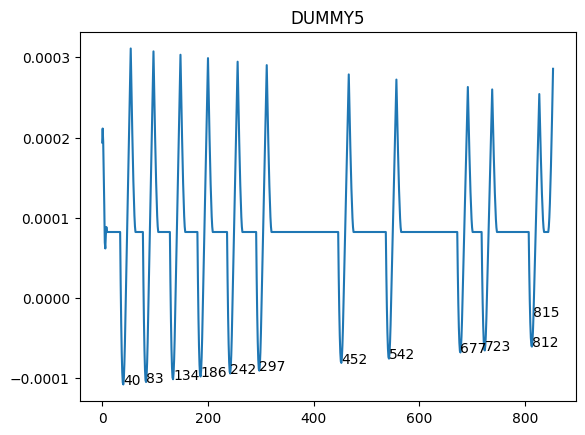

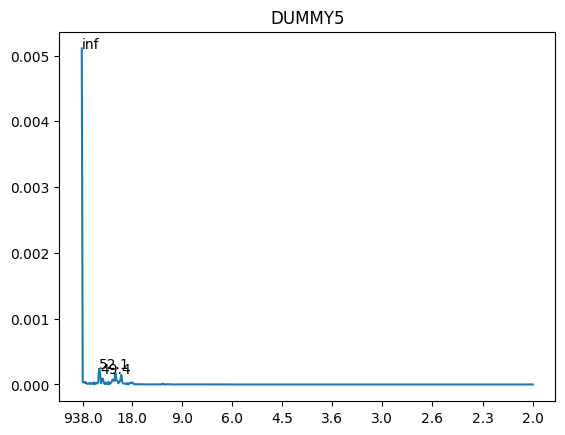

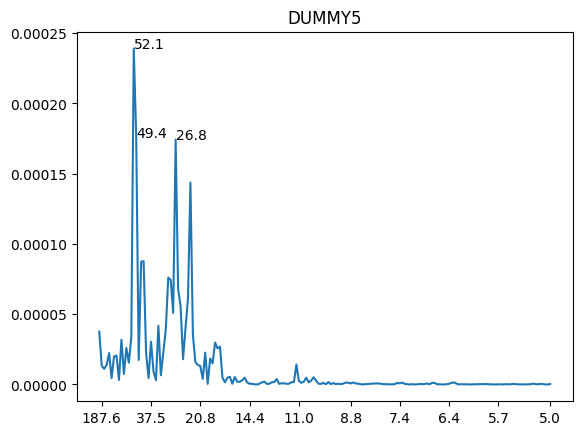

x_right,x,y
f64,f64,f64
6.007042,41.048122,-0.003608
470.551643,488.57277,-0.001601
null,2.002347,-0.002292
225.264085,225.264085,-0.000341
318.373239,324.380282,-0.000545
…,…,…
200.234742,215.252347,-0.0025
528.619718,540.633803,-0.002722
431.505869,447.524648,-0.002492


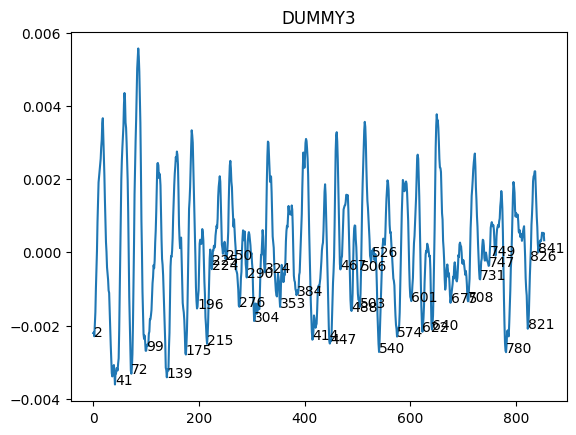

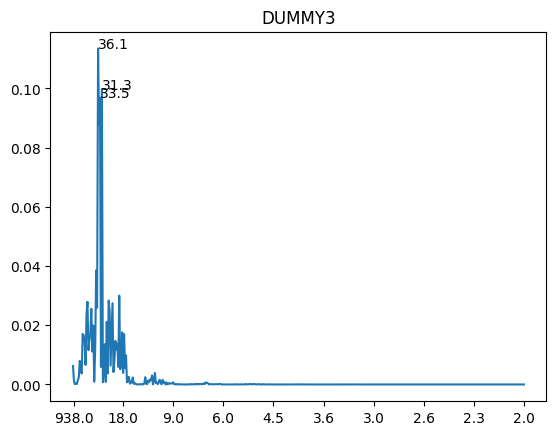

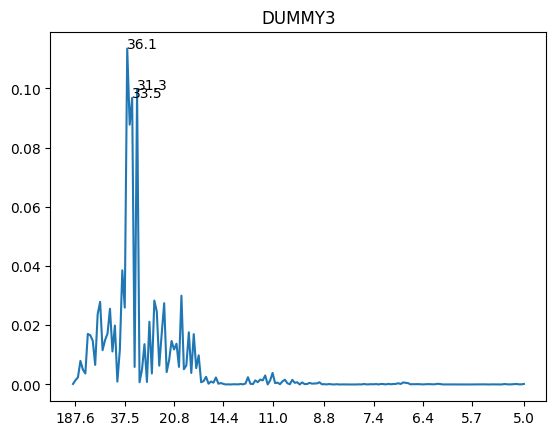

x_right,x,y
f64,f64,f64
143.16784,191.224178,-0.000097
371.435446,416.488263,-0.000083
null,6.007042,-0.000297
195.228873,234.274648,-0.000095
707.829812,746.875587,-0.000064
…,…,…
89.10446,139.163146,-0.000101
238.279343,279.327465,-0.000092
328.384977,367.430751,-0.000086


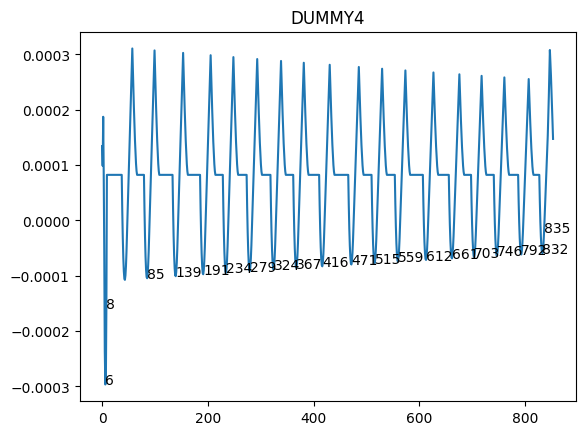

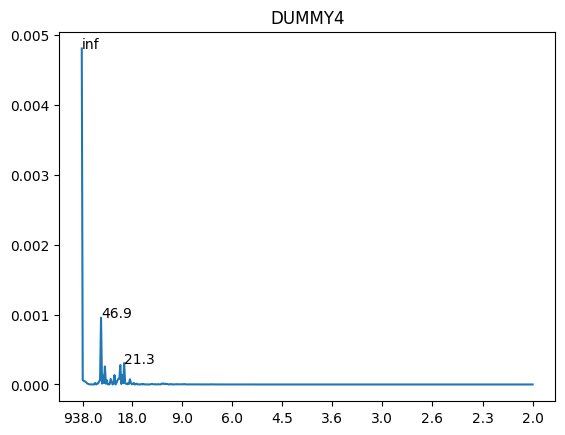

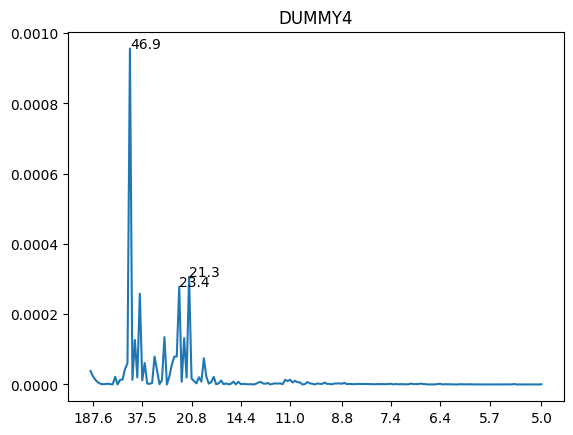

x_right,x,y
f64,f64,f64
301.353286,344.403756,-0.000885
51.059859,94.110329,-0.000972
501.588028,544.638498,-0.00082
701.82277,744.873239,-0.000759
null,44.051643,-0.000991
…,…,…
801.940141,844.99061,-0.000744
751.881455,794.931925,-0.000744
201.235915,244.286385,-0.000919


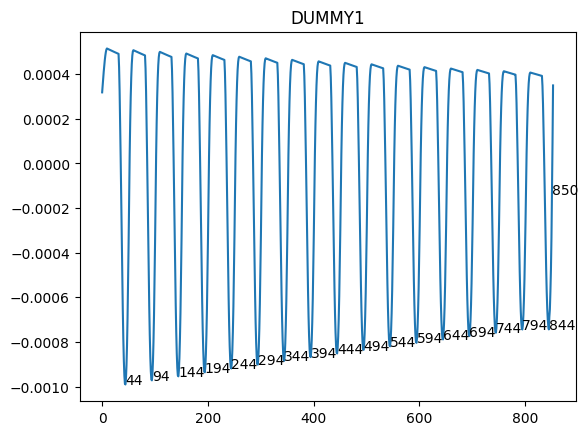

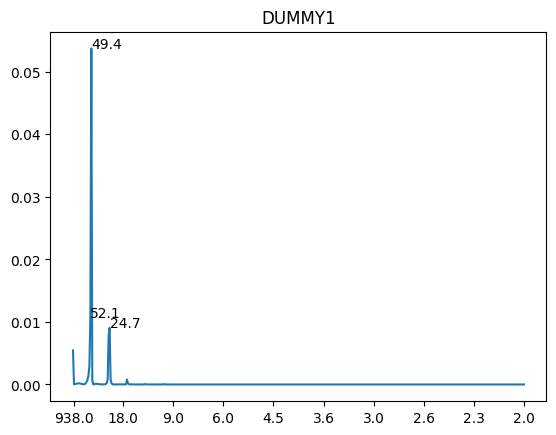

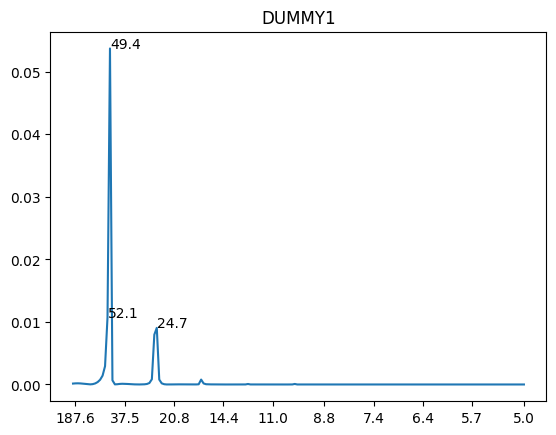

In [631]:
# test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]
# test_tickers = [test_tickers[5]]
# test_tickers = ['NRDY']
dummy_tickers = df.filter(pl.col('ticker').str.head(5) == 'DUMMY')['ticker'].unique().to_list()
test_tickers = ['NRDY', *dummy_tickers]
# test_tickers = ['DUMMY4']

print(test_tickers)

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))
WINDOW_SIZE = 10
DEBUG = False

detrended_df = (
    filtered_df.group_by('ticker').map_groups(detrend_moving_avg).drop_nulls()
    # .with_columns(pl.when(abs(pl.col('price')) > .1).then(pl.col('price')).otherwise(0).alias('price'))
    .with_columns(pl.mean_horizontal(
        *[pl.col('price').shift(i) * smoothing_function(i) for i in range(-smoothing_distance, smoothing_distance)]
    ).alias('price'))
)

for ticker in test_tickers:
    ticker_df = detrended_df.filter(pl.col('ticker') == pl.lit(ticker))
    

    N = ticker_df.shape[0]
    x_all = np.linspace(0, N, N)
    y_all = ticker_df['price'].to_numpy()

    overlap = .1
    windows = 1
    L = y_all.shape[-1]
    W = L // windows
    N = int(W * (1 + overlap) // 1)

    # for padding in [0, 50, 100, 500, 1000, -1000]:
    for window in range(windows):
        start = int(window * W)
        end = int(min(start + N, L) // 1)

        x = x_all[start: end]
        y = y_all[start: end]

        yf = sp.fft.fft(y, n=N)[:N//2]

        xf = sp.fft.fftfreq(N)[:N//2]

        psd = np.abs(yf) ** 2

        # plotting local minimums
        fig, ax = plt.subplots()

        plt.plot(x, y)
        min_points_df = pl.DataFrame({'x': x, 'y': y})
        first_negatives_df = min_points_df.filter((pl.col('y') < 0, pl.col('y').shift(-1) >= 0)).with_columns(pl.col('x').alias('x_right'))
        
        min_points_df = (min_points_df
            .join_asof(first_negatives_df, on='x')
            .group_by(pl.col('x_right'))
            .agg(x=pl.col('x').get(pl.col('y').arg_min()), y=pl.col('y').min())              
        )

        display(min_points_df)
        for row in min_points_df.iter_rows():
            plt.text(row[1], row[2], int(row[1]))

        plt.title(ticker) 
        plt.show()

        plot_psd(xf, psd)
        plot_psd(xf, psd, 5, 300)